In [2]:
import csv as csv

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
def readCrashData(accYearStart, accYearEnd, nrows=None):
    dir = 'NHTSA-FARS-download/'
    usecols = ['MOD_YEAR', 'MAKE', 'MODEL', 'DEATHS']

    dfCrash = None
    for accYear in range(accYearStart, accYearEnd + 1):

        print( accYear,'', end='')
        df = pd.read_csv(
            f'{dir}vehicle{accYear}.csv', encoding='latin1', header=0, usecols=usecols, nrows=nrows)  
            #.astype(str)      # , dtype={'DEATHS':'int32'}        

        df['ACC_YEAR'] = accYear
        if dfCrash is None:
            dfCrash = df
        else:
            dfCrash = pd.concat([dfCrash, df], ignore_index=True)
    
    print('')
    dfCrash = dfCrash.rename(columns = {'MAKE':'Make_ID', 'MODEL':'Model_ID', 'DEATHS':'fatalities'})

    return dfCrash


def aggregate(dfCrash, filterCondition='MOD_YEAR>=1999', groupBy=['MOD_YEAR', 'Make_ID', 'Model_ID','ACC_YEAR']):
    print('filtering by',filterCondition, ', aggregating by',groupBy)

    dfCrashAgg = dfCrash.query(filterCondition).groupby(groupBy) \
        .agg(fatalities=pd.NamedAgg(column='fatalities', aggfunc=sum)) \
        .reset_index()

    return dfCrashAgg


if __name__ == '__main__':
    
    df_agg = aggregate( readCrashData(accYearStart=2000, accYearEnd=2020)
                       ,filterCondition = 'MOD_YEAR>=1999'
                       ,groupBy = ['MOD_YEAR', 'Make_ID', 'Model_ID','ACC_YEAR']
                      )
    df_agg.to_pickle( 'program_data/master_crash_aggregate.pkl')
    
    # test aggregate
    dfMasterCrashAgg = pd.read_pickle('program_data/master_crash_aggregate.pkl')
    print(dfMasterCrashAgg[:5])


2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 
filtering by MOD_YEAR>=1999 , aggregating by ['MOD_YEAR', 'Make_ID', 'Model_ID', 'ACC_YEAR']
   MOD_YEAR  Make_ID  Model_ID  ACC_YEAR  fatalities
0      1999        2       403      2000          13
1      1999        2       403      2001          11
2      1999        2       403      2002           9
3      1999        2       403      2003          11
4      1999        2       403      2004          20


In [4]:
def reaggregate( dfCrashAgg, groupBy=None):
    # If groupBy==None, then further aggregation is done, i.e. use agg level of dfCrashAgg.
    # Otherwise groupBy should be list of columns, e.g. ['MOD_YEAR', 'Make_ID', 'ACC_YEAR']

    if groupBy != None:
        df = aggregate( dfCrashAgg, groupBy=groupBy )
    else:
        df = dfCrashAgg
    
    return df


if __name__ == '__main__':
    
    #test re-aggregate
    dfagg2 = reaggregate(dfMasterCrashAgg, groupBy=['MOD_YEAR', 'Make_ID', 'ACC_YEAR'])
    print(dfagg2[:5])
    
    dfagg2 = reaggregate(dfMasterCrashAgg)
    print(dfagg2[:5])            
        

filtering by MOD_YEAR>=1999 , aggregating by ['MOD_YEAR', 'Make_ID', 'ACC_YEAR']
   MOD_YEAR  Make_ID  ACC_YEAR  fatalities
0      1999        2      2000          43
1      1999        2      2001          40
2      1999        2      2002          36
3      1999        2      2003          68
4      1999        2      2004          68
   MOD_YEAR  Make_ID  Model_ID  ACC_YEAR  fatalities
0      1999        2       403      2000          13
1      1999        2       403      2001          11
2      1999        2       403      2002           9
3      1999        2       403      2003          11
4      1999        2       403      2004          20


In [5]:
def getSales( verbose=False, nrows = None):
    dir = 'car_sales_data/'

    df_original = pd.read_csv(f'{dir}car_sales_ID_NoOther.csv', encoding='latin1', header=0, nrows=nrows)

    df_melted = pd.melt(df_original
                        , id_vars = ['Make_Name', 'Model_Name','Model_ID','Make_ID']
                        , value_vars = [str(x) for x in range(2005,2021+1)]
                        , var_name = 'Sales_Year'
                        , value_name = 'Sales'
                       ).astype( {'Model_ID':'int32','Make_ID':'int32', 'Sales_Year':'int32', 'Sales':'int32'})  
    
    if verbose:
              
        print("df_original number of records is ", len(df_original))
#         print(df_original.dtypes)  
        
        print("df_melted number of records is ", len(df_melted))
#         print(df_melted.dtypes)

#         print(df_melted[5500:5520])
#         print(df_melted.query('Sales!="0"')[:20])
        print(df_melted.query('Make_Name=="Acura" and Model_Name=="MDX"'))
        print(df_melted.query('Make_Name=="Tesla" or  Model_Name=="Tesla"'))
        
        test2 = df_melted.query('Make_ID==49 and Model_ID==40 and Sales_Year==2005')
        print(test2)
        print(test2.dtypes)

    return df_melted



# def joinCrashSales( dfCrash, dfSales):
#     dfCrashSales = dfCrash.merge( dfSales, on=['Make_ID','Model_ID'], how='left')
#     print(dfCrashSales.query('Make_Name=="Acura" and Model_Name=="MDX"'))
    
#     return dfCrashSales

    

if __name__ == '__main__':
    df = getSales(verbose=True)
    df.to_pickle( 'program_data/sales_melted.pkl')
    
    dfSales = pd.read_pickle('program_data/sales_melted.pkl')
    print(dfSales[:5])
    


df_original number of records is  607
df_melted number of records is  10319
     Make_Name Model_Name  Model_ID  Make_ID  Sales_Year  Sales
3        Acura        MDX       421       54        2005  57948
610      Acura        MDX       421       54        2006  54121
1217     Acura        MDX       421       54        2007  58606
1824     Acura        MDX       421       54        2008  45377
2431     Acura        MDX       421       54        2009  31178
3038     Acura        MDX       421       54        2010  47210
3645     Acura        MDX       421       54        2011  43271
4252     Acura        MDX       421       54        2012  50854
4859     Acura        MDX       421       54        2013  53040
5466     Acura        MDX       421       54        2014  65603
6073     Acura        MDX       421       54        2015  58208
6680     Acura        MDX       421       54        2016  55495
7287     Acura        MDX       421       54        2017  54886
7894     Acura        MDX   

In [6]:
# df_sales:  
#      Make_Name Model_Name  Model_ID  Make_ID  Sales_Year  Sales
# 3        Acura        MDX       421       54        2005  57948
# 610      Acura        MDX       421       54        2006  54121
# 1217     Acura        MDX       421       54        2007  58606

def lookupSales(dfSales, Sales_Year, Make_ID, Model_ID, verbose=False ):
    '''
    Get closest Sales_Year sales.
    E.g. if 2000 is requested, 2005 sales is returned since that's the earliest sales data available.
    
    if Model_ID==None, then Make level sales will be returned.
    '''
    
    condition = []
    if Sales_Year != None:
        condition.append(f'Sales_Year>={Sales_Year}')
    if Make_ID != None:
        condition.append(f'Make_ID=={Make_ID}')
    if Model_ID != None:
        condition.append(f'Model_ID=={Model_ID}')
    
    condition = ' and '.join(condition)
    
        
    df = dfSales.query(condition)

    if df.empty:
        year, sales = None, None
    
    else:
        if Model_ID == None:
            df = df.groupby(['Make_ID','Sales_Year']) \
                    .agg(Sales=pd.NamedAgg(column='Sales', aggfunc=sum)) \
                    .reset_index()

        
        year, sales = df.Sales_Year.tolist()[0], df.Sales.tolist()[0]

                
    if verbose:
        print(condition)
#         print(df)
        print('year',year,'sales',sales)
        print()

    return year, sales

if __name__ == '__main__':
    year, sales = lookupSales(dfSales, Sales_Year=2005, Make_ID=49, Model_ID=40, verbose=True)
    year, sales = lookupSales(dfSales, 2005, 49, None , True)
    year, sales = lookupSales(dfSales, 2005, 49, 4000 , True)

    

Sales_Year>=2005 and Make_ID==49 and Model_ID==40
year 2005 sales 431703

Sales_Year>=2005 and Make_ID==49
year 2005 sales 1800915

Sales_Year>=2005 and Make_ID==49 and Model_ID==4000
year None sales None



filtering by MOD_YEAR>=1999 , aggregating by ['MOD_YEAR', 'Make_ID', 'ACC_YEAR']


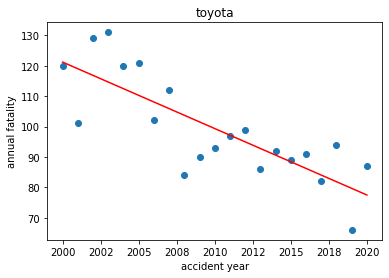

Slope -2.1857142857143574 intercept 4492.619047619193
Initial fatality rate is 121.19047619047797 per year


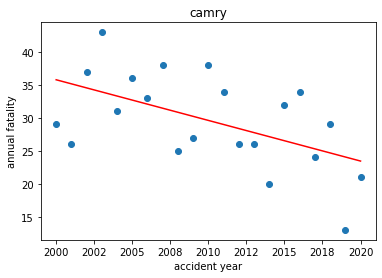

Slope -0.6168831168831609 intercept 1269.554112554201
Initial fatality rate is 35.78787878787921 per year


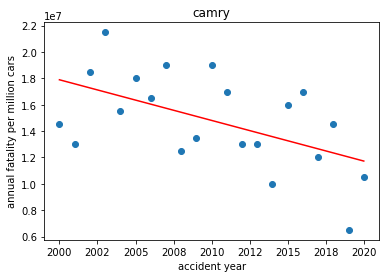

Slope -308441.55844158056 intercept 634777056.2771009
Initial fatality rate is 17893939.393939734 per year


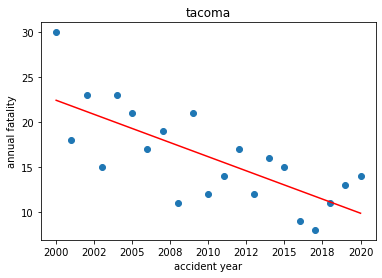

Slope -0.6285714285714206 intercept 1279.5714285714128
Initial fatality rate is 22.42857142857156 per year


In [7]:
def linear_regress(dfCrashAgg, name, filterCondition, denom=None, showPlot=True):
    k = name
    v = dfCrashAgg.query(filterCondition)
    
    if v.empty:
        return None,None,None
    
    # start of linear regression calculation
    # create lists for year and fatalities to iterate through
    x_years = v['ACC_YEAR'].to_list()
    y_fatal = v['fatalities'].to_list()
    
    if denom != None:
        y_fatal = [y/(denom/1e6) for y in y_fatal]
        permillion = ' per million cars'
    else:
        permillion = ''
    
    yearOne = min(x_years)

    # find number of years of data
    num_years = len(x_years)

    # get regression coefficients for all data provided at least 2 years of data
    # otherwise coefficients = None and assign coefficients to coeff_all dictionary

    slope, intercept, initFatality = None, None, None
    if num_years > 1:
        slope, intercept = np.polyfit(x_years, y_fatal, 1)
        y_cal2 = []
        for m in range(len(x_years)):
            y_cal2.append(x_years[m]*slope + intercept)

    # print linear regression on top of scatter plot (if slope != None)
    if  slope != None:   
        initFatality = slope * yearOne + intercept
        
        if showPlot:
            
            fig,ax = plt.subplots()
            ax.scatter(x_years,y_fatal)
            ax.set_title(k)
            
            ax.plot(x_years, y_cal2, 'r') 
            ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:4.0f}'))
            ax.xaxis.set_label_text('accident year')
            ax.yaxis.set_label_text('annual fatality' + permillion)

            plt.show()        
            print(f'Slope {slope} intercept {intercept}')
            print(f'Initial fatality rate is {initFatality} per year')
    
    return slope, intercept, initFatality

if __name__ == '__main__':
    dfCrashAggByMake = reaggregate(dfMasterCrashAgg, groupBy=['MOD_YEAR', 'Make_ID', 'ACC_YEAR'])
    linear_regress(dfCrashAggByMake,'toyota' , "MOD_YEAR==1999 and Make_ID==49 ")  

    linear_regress(dfMasterCrashAgg,'camry' , "MOD_YEAR==1999 and Make_ID==49 and Model_ID==40  ")  
    linear_regress(dfMasterCrashAgg,'camry' , "MOD_YEAR==1999 and Make_ID==49 and Model_ID==40  ", denom=2)  


    # linear_regress(dfMasterCrashAgg,'camry'        , "MOD_YEAR==1999 and Make_ID==49 and Model_ID==40  ")  
    linear_regress(dfMasterCrashAgg,'tacoma'       , "MOD_YEAR==1999 and Make_ID==49 and Model_ID==472 ")
    # linear_regress(dfMasterCrashAgg,'mustang'      , "MOD_YEAR==1999 and Make_ID==12 and Model_ID==3   ")
    # linear_regress(dfMasterCrashAgg,'ford_f_series', "MOD_YEAR==1999 and Make_ID==12 and Model_ID==481 ")
    # linear_regress(dfMasterCrashAgg,'crown_vicoria', "MOD_YEAR==1999 and Make_ID==12 and Model_ID==16  ")

    # df_agg = aggregate(df_final, ['MOD_YEAR', 'Make_ID','YEAR'])
    # linear_regress(df_agg,'toyota', "MOD_YEAR==1999 and Make_ID==49 ")
    # linear_regress(df_agg,'ford'  , "MOD_YEAR==1999 and Make_ID==12 ")

filtering by MOD_YEAR>=1999 , aggregating by ['MOD_YEAR', 'Make_ID', 'ACC_YEAR']


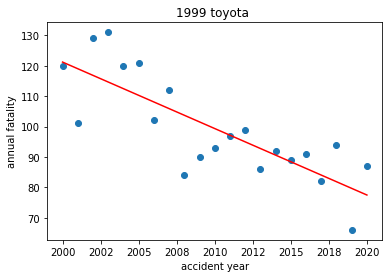

Slope -2.1857142857143574 intercept 4492.619047619193
Initial fatality rate is 121.19047619047797 per year


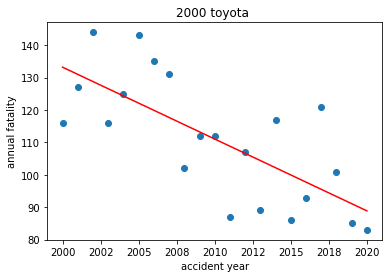

Slope -2.2168831168832472 intercept 4566.9826839829475
Initial fatality rate is 133.21645021645327 per year


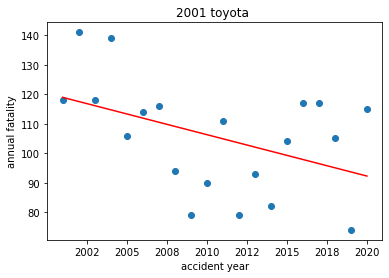

Slope -1.404511278195416 intercept 2929.369924811883
Initial fatality rate is 118.94285714285525 per year


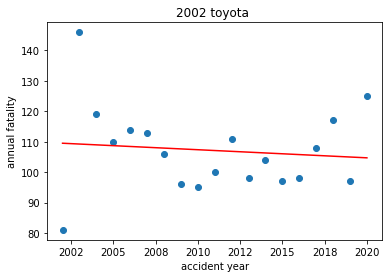

Slope -0.2666666666666629 intercept 643.3719298245538
Initial fatality rate is 109.50526315789477 per year


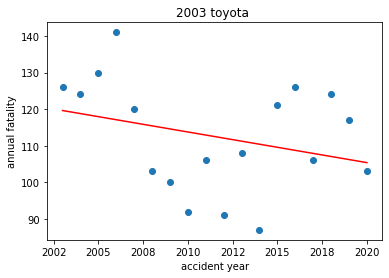

Slope -0.8369453044375686 intercept 1796.015479876169
Initial fatality rate is 119.614035087719 per year


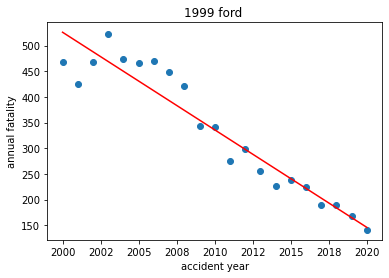

Slope -18.998701298702045 intercept 38523.24675324826
Initial fatality rate is 525.84415584417 per year


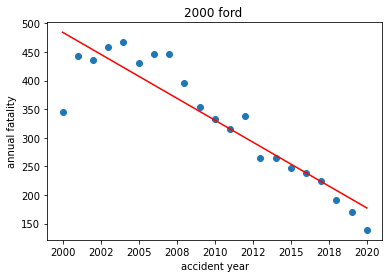

Slope -15.36623376623466 intercept 31217.082251084055
Initial fatality rate is 484.6147186147318 per year


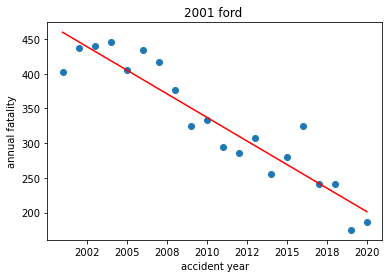

Slope -13.600751879698432 intercept 27674.761654133683
Initial fatality rate is 459.65714285711874 per year


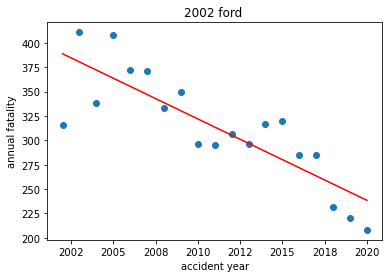

Slope -8.359649122806955 intercept 17124.885964912155
Initial fatality rate is 388.86842105262986 per year


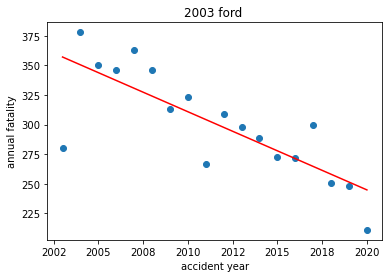

Slope -6.603715170278297 intercept 13584.317509459237
Initial fatality rate is 357.0760233918081 per year
filtering by MOD_YEAR>=1999 , aggregating by ['MOD_YEAR', 'Make_ID', 'ACC_YEAR']


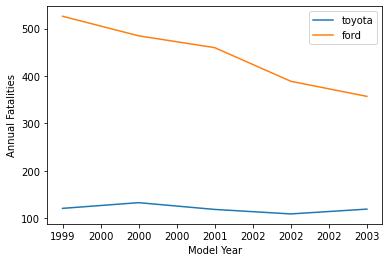

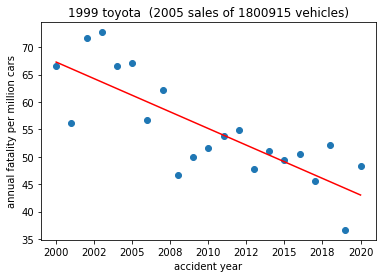

Slope -1.2136687659963716 intercept 2494.631366621517
Initial fatality rate is 67.29383462877377 per year


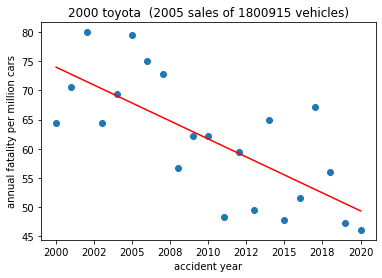

Slope -1.2309759854758546 intercept 2535.9235077629705
Initial fatality rate is 73.9715368112611 per year


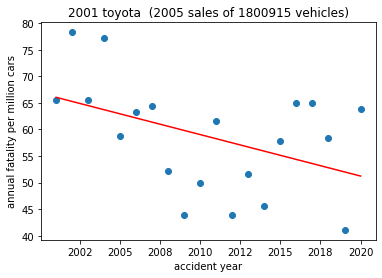

Slope -0.7798876005782696 intercept 1626.600880558982
Initial fatality rate is 66.04579180186465 per year


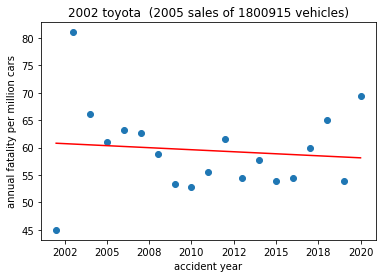

Slope -0.14807287776861372 intercept 357.2472492175111
Initial fatality rate is 60.80534792474646 per year


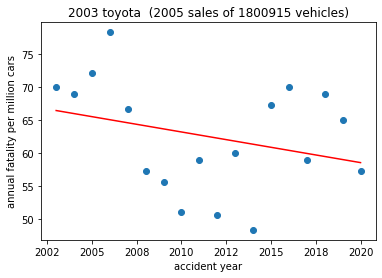

Slope -0.4647333741112537 intercept 997.2794273334216
Initial fatality rate is 66.41847898858043 per year


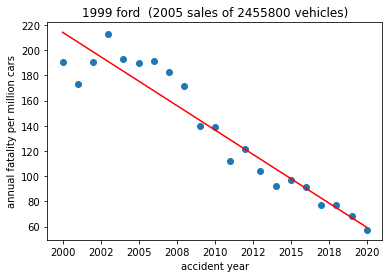

Slope -7.73625755301818 intercept 15686.638469438987
Initial fatality rate is 214.12336340262664 per year


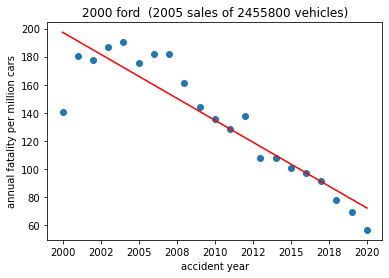

Slope -6.257119377080651 intercept 12711.573520272033
Initial fatality rate is 197.33476611073274 per year


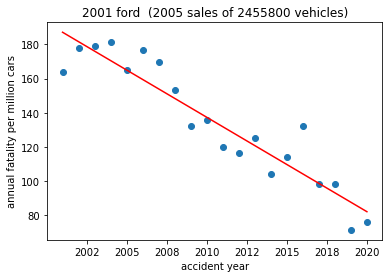

Slope -5.538216418152307 intercept 11269.14311187136
Initial fatality rate is 187.1720591485955 per year


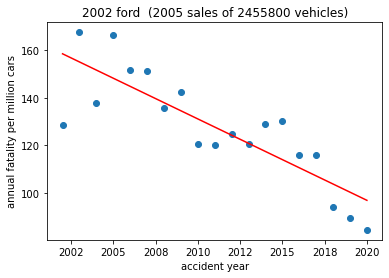

Slope -3.404043131691079 intercept 6973.241292007553
Initial fatality rate is 158.34694236201267 per year


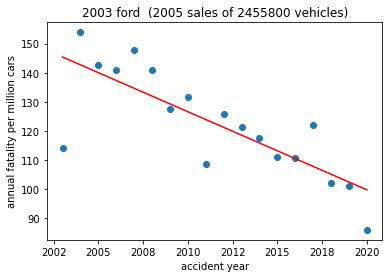

Slope -2.689028084647893 intercept 5531.524354368938
Initial fatality rate is 145.4011008192074 per year


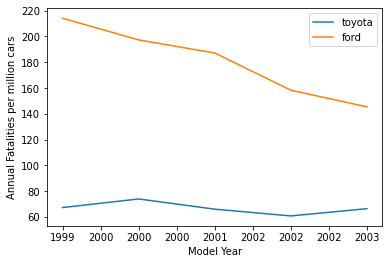

In [8]:
def summarize_by_makeyear( dfCrashAgg, modelYrStart, modelYrEnd, makes_dict, dfSales=pd.DataFrame()): 
    # BY MANUFACTURER **********
    # if dfSales is provided, it'll be used for normalization
    
    df = reaggregate(dfCrashAgg, groupBy=['MOD_YEAR', 'Make_ID', 'ACC_YEAR'])
    series={}    
    
    for makeName,ID in makes_dict.items():
        Make_ID  = ID['Make_ID']
        # Model_ID = ID['Model_ID']
        condition = f'Make_ID=={Make_ID}'  #' and Model_ID=={Model_ID}'
        
        x,y=[],[]
        for modelYear in range(modelYrStart, modelYrEnd + 1):
            
            if not dfSales.empty:
                year, sales = lookupSales(
                    dfSales, Sales_Year=modelYear, Make_ID=Make_ID, Model_ID=None, verbose=False)
                
                # sales could be None if not found
                if sales != None:
                    salesTitle = f' ({year} sales of {sales} vehicles)'
                    
            else:
                sales = None
                salesTitle = ''
            
            if dfSales.empty or sales!=None:
                _,_, initFatality = linear_regress(
                      dfCrashAgg      = df
                    , name            = f'{modelYear} {makeName} {salesTitle}'
                    , filterCondition = f'MOD_YEAR=={modelYear} and ACC_YEAR>=MOD_YEAR and '+condition
                    , denom           = sales
                    , showPlot        = (modelYear>=modelYrStart)
                    )

                if initFatality != None:
                    x.append(modelYear)
                    y.append(initFatality)
        
        series[makeName] = [x,y]

    fig, ax = plt.subplots()

    for makeName,data in series.items():
        ax.plot(data[0], data[1], label=makeName)
    
    if not dfSales.empty:
        permillion = ' per million cars'
    else:
        permillion = ''
    
    ax.set_xlabel('Model Year')  # Add an x-label to the axes.
    ax.set_ylabel('Annual Fatalities' + permillion)  # Add a y-label to the axes.
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:4.0f}'))
    ax.legend()
    

if __name__ == '__main__':
    #     df_agg = aggregate(df_final, ['MOD_YEAR', 'Make_ID', 'Model_ID','ACC_YEAR'])
    x = {}
    x['toyota' ]        = {'Make_ID':49}   
    x['ford'] = {'Make_ID':12}   
    
    summarize_by_makeyear( dfMasterCrashAgg, modelYrStart=1999, modelYrEnd=2003, makes_dict=x)
    summarize_by_makeyear( dfMasterCrashAgg, modelYrStart=1999, modelYrEnd=2003, makes_dict=x, dfSales=dfSales)
    


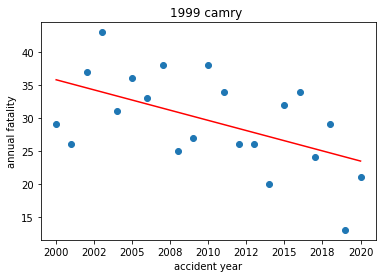

Slope -0.6168831168831609 intercept 1269.554112554201
Initial fatality rate is 35.78787878787921 per year


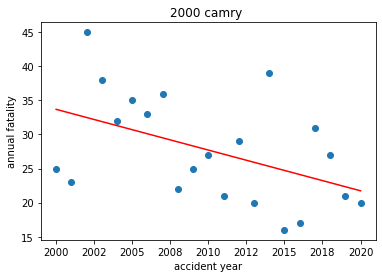

Slope -0.5974025974026497 intercept 1228.4935064936117
Initial fatality rate is 33.6883116883123 per year


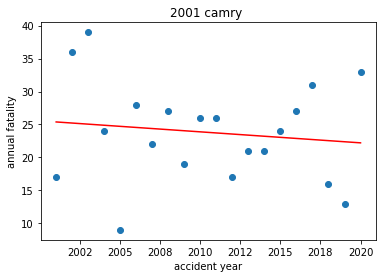

Slope -0.1669172932330375 intercept 359.3872180450217
Initial fatality rate is 25.385714285713675 per year


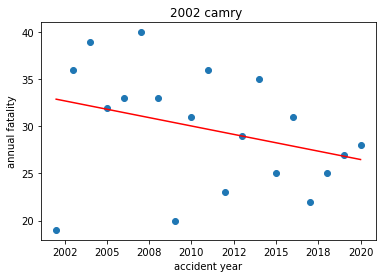

Slope -0.35614035087719076 intercept 745.8824561403464
Initial fatality rate is 32.88947368421054 per year


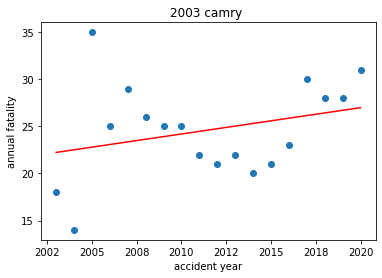

Slope 0.2796697626419029 intercept -537.9446164430764
Initial fatality rate is 22.233918128655205 per year


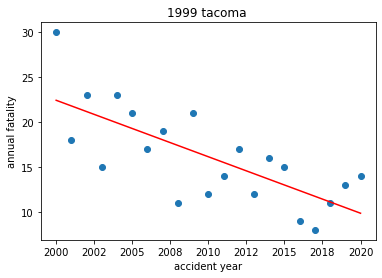

Slope -0.6285714285714206 intercept 1279.5714285714128
Initial fatality rate is 22.42857142857156 per year


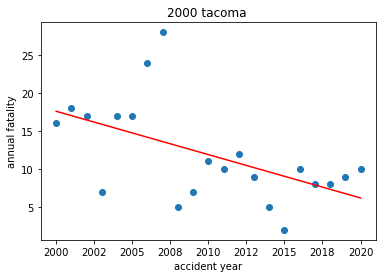

Slope -0.5701298701298934 intercept 1157.865800865848
Initial fatality rate is 17.60606060606142 per year


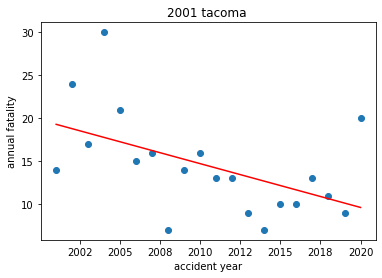

Slope -0.5090225563909382 intercept 1037.8398496239809
Initial fatality rate is 19.28571428571354 per year


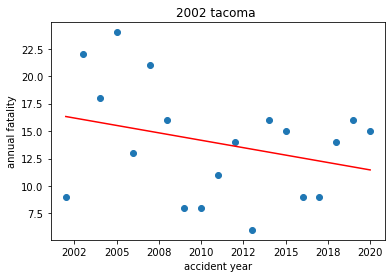

Slope -0.27017543859648613 intercept 557.2175438596389
Initial fatality rate is 16.32631578947371 per year


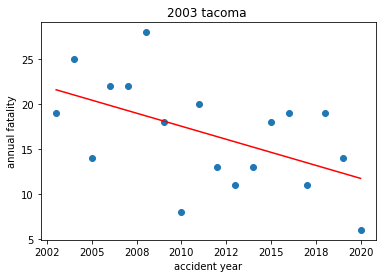

Slope -0.5799793601650957 intercept 1183.2951496387561
Initial fatality rate is 21.596491228069453 per year


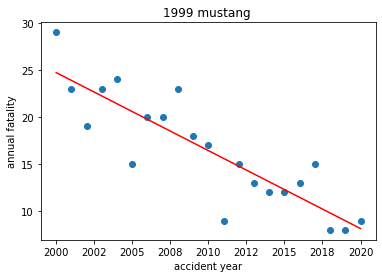

Slope -0.828571428571438 intercept 1681.857142857162
Initial fatality rate is 24.714285714286007 per year


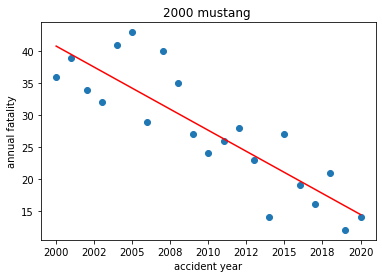

Slope -1.3207792207792723 intercept 2682.3852813853855
Initial fatality rate is 40.826839826841024 per year


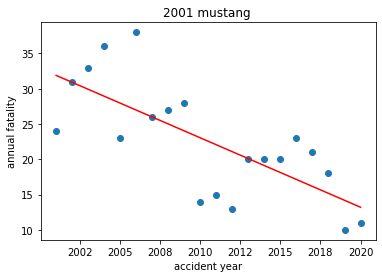

Slope -0.9827067669172176 intercept 1998.2819548870648
Initial fatality rate is 31.88571428571231 per year


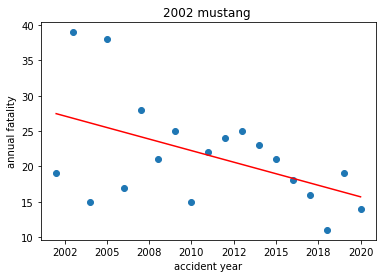

Slope -0.6543859649122722 intercept 1337.5491228070007
Initial fatality rate is 27.46842105263181 per year


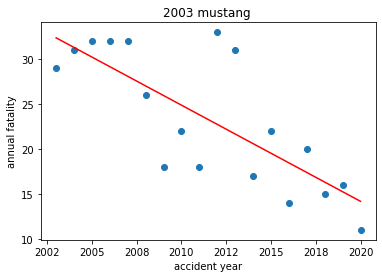

Slope -1.0701754385964644 intercept 2175.935672514566
Initial fatality rate is 32.37426900584751 per year


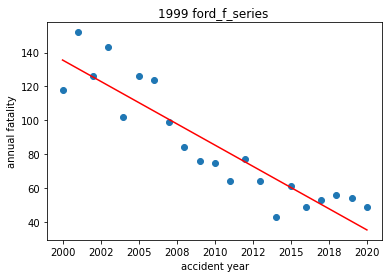

Slope -5.0129870129872245 intercept 10161.580086580514
Initial fatality rate is 135.6060606060655 per year


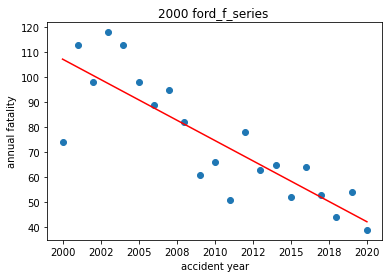

Slope -3.249350649350853 intercept 6605.9567099571195
Initial fatality rate is 107.25541125541349 per year


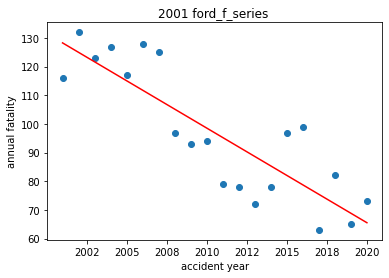

Slope -3.3037593984960534 intercept 6739.108270676312
Initial fatality rate is 128.28571428570922 per year


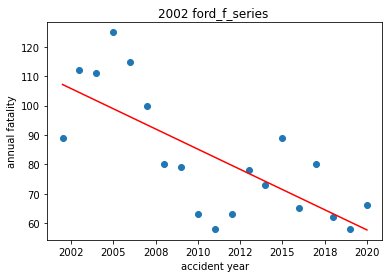

Slope -2.7526315789473523 intercept 5617.963157894705
Initial fatality rate is 107.19473684210516 per year


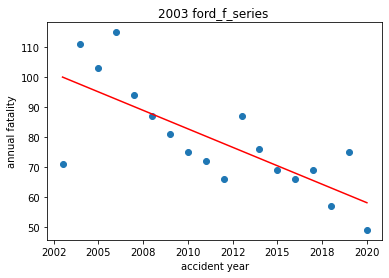

Slope -2.467492260061795 intercept 5042.416236669855
Initial fatality rate is 100.02923976607963 per year


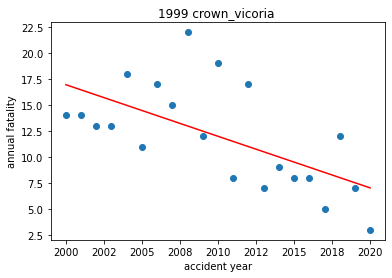

Slope -0.496103896103916 intercept 1009.1688311688713
Initial fatality rate is 16.96103896103932 per year


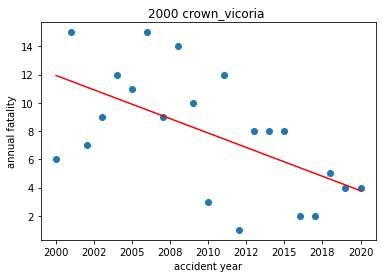

Slope -0.40779220779223835 intercept 827.5194805195421
Initial fatality rate is 11.935064935065384 per year


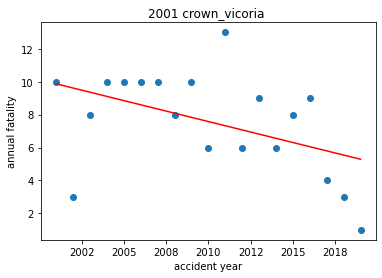

Slope -0.2543859649122771 intercept 518.8947368420983
Initial fatality rate is 9.868421052631788 per year


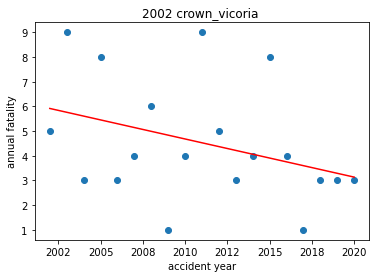

Slope -0.15438596491227916 intercept 314.99649122806716
Initial fatality rate is 5.915789473684299 per year


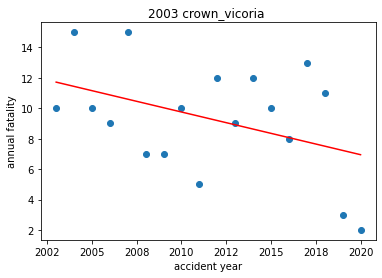

Slope -0.28070175438595385 intercept 573.9649122806793
Initial fatality rate is 11.719298245613686 per year


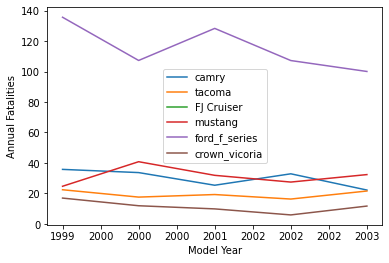

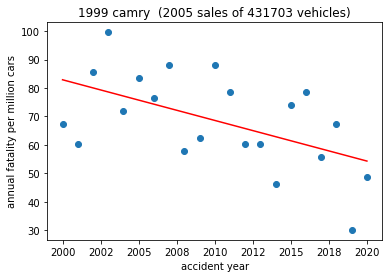

Slope -1.4289525828710028 intercept 2940.804471023367
Initial fatality rate is 82.89930528136165 per year


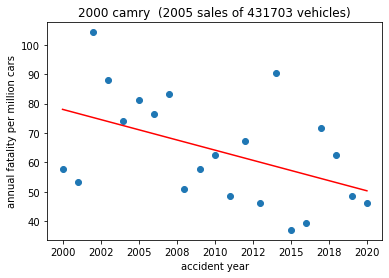

Slope -1.3838277644645731 intercept 2845.6913815600346
Initial fatality rate is 78.03585263088826 per year


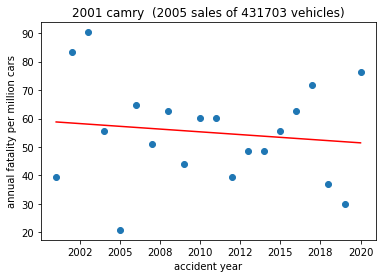

Slope -0.3866484440298942 intercept 832.4871915298746
Initial fatality rate is 58.80365502605639 per year


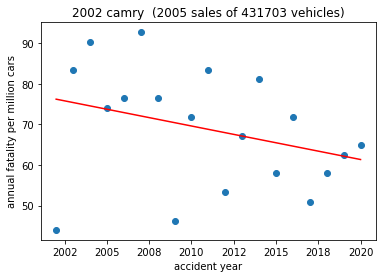

Slope -0.8249661245745121 intercept 1727.7675998090035
Initial fatality rate is 76.18541841083015 per year


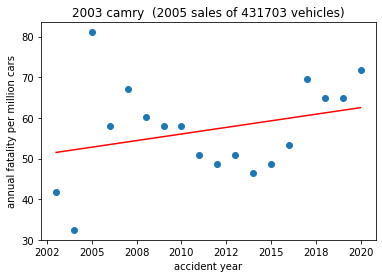

Slope 0.6478290923201895 intercept -1246.0988606590092
Initial fatality rate is 51.50281125833021 per year


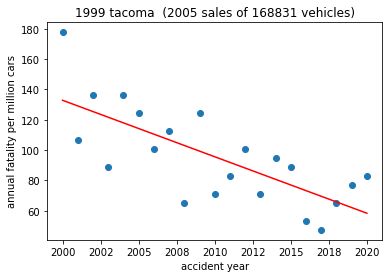

Slope -3.72308064615752 intercept 7579.0075790074825
Initial fatality rate is 132.84628669244285 per year


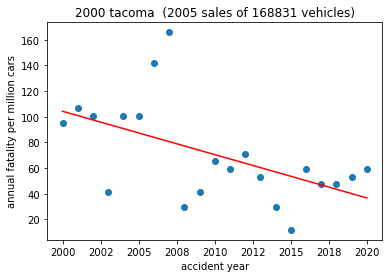

Slope -3.376926453849669 intercept 6858.135063263548
Initial fatality rate is 104.28215556420946 per year


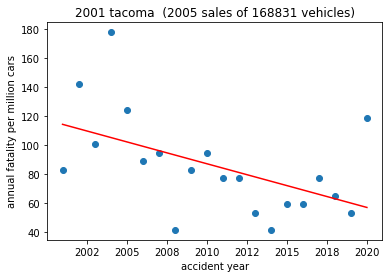

Slope -3.014982772067561 intercept 6147.211410368836
Initial fatality rate is 114.23088346164695 per year


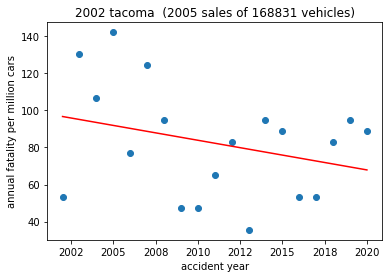

Slope -1.6002715058045383 intercept 3300.4456756143045
Initial fatality rate is 96.70212099361879 per year


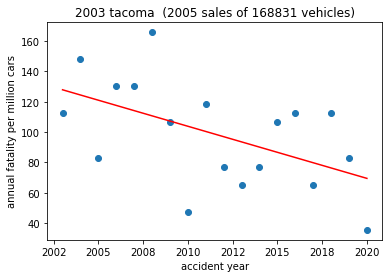

Slope -3.4352657993205935 intercept 7008.755202769368
Initial fatality rate is 127.91780673021913 per year


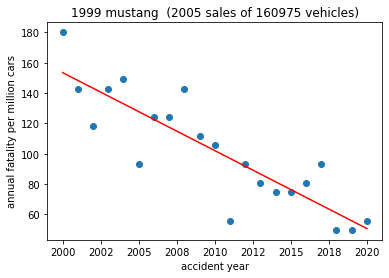

Slope -5.14720564417728 intercept 10447.940008430885
Initial fatality rate is 153.52872007632504 per year


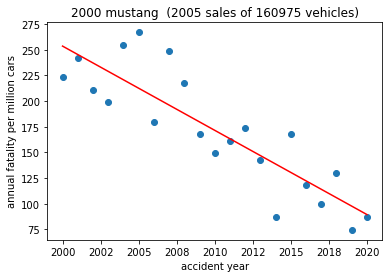

Slope -8.204871692991288 intercept 16663.365624385064
Initial fatality rate is 253.6222384024877 per year


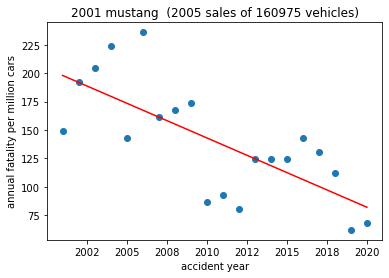

Slope -6.104716675988307 intercept 12413.616741028514
Initial fatality rate is 198.078672375912 per year


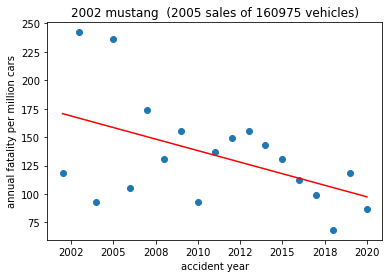

Slope -4.065140331804767 intercept 8309.048751713006
Initial fatality rate is 170.63780743986172 per year


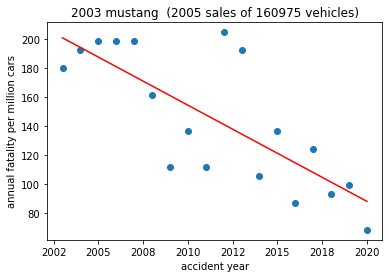

Slope -6.648084724935327 intercept 13517.227349057714
Initial fatality rate is 201.11364501225398 per year


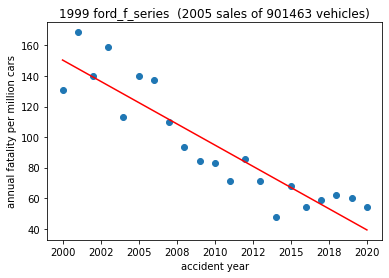

Slope -5.560945943413346 intercept 11272.320757014448
Initial fatality rate is 150.42887018775582 per year


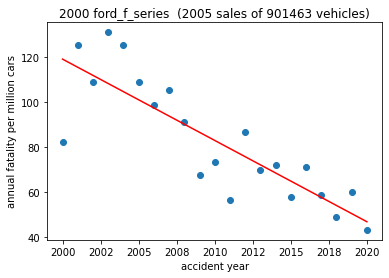

Slope -3.6045302462229216 intercept 7328.039764202327
Initial fatality rate is 118.9792717564842 per year


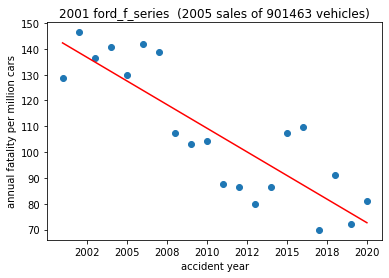

Slope -3.6648862998215725 intercept 7475.745838349787
Initial fatality rate is 142.30835240682063 per year


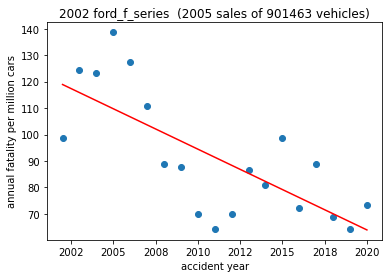

Slope -3.0535158724732483 intercept 6232.050741843764
Initial fatality rate is 118.91196515232059 per year


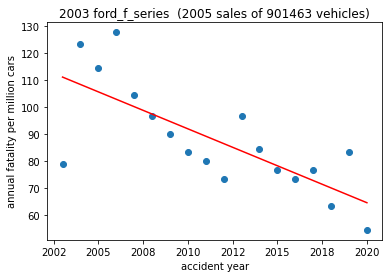

Slope -2.7372085821179497 intercept 5593.592012838964
Initial fatality rate is 110.96322285671067 per year


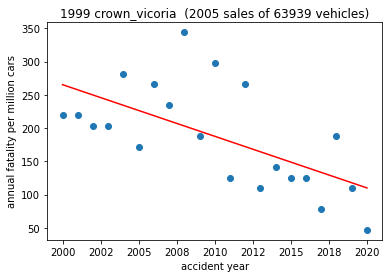

Slope -7.759018691313848 intercept 15783.30645097471
Initial fatality rate is 265.2690683470137 per year


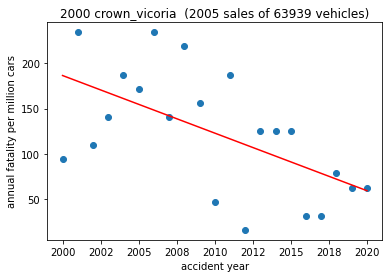

Slope -6.377832117991184 intercept 12942.327539053504
Initial fatality rate is 186.6633030711364 per year


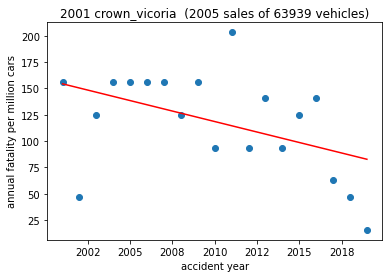

Slope -3.9785727789342533 intercept 8115.465316037136
Initial fatality rate is 154.34118538969506 per year


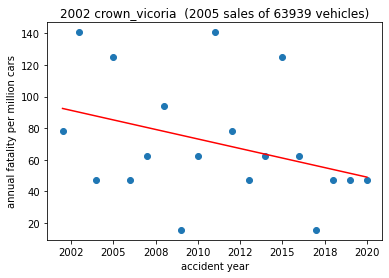

Slope -2.4145821003187287 intercept 4926.515760773035
Initial fatality rate is 92.5223959349405 per year


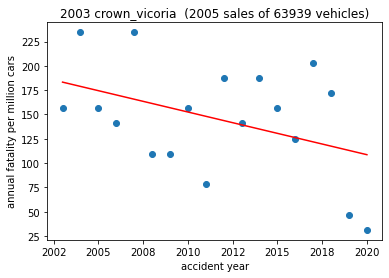

Slope -4.39014927330665 intercept 8976.757726593778
Initial fatality rate is 183.28873216055763 per year


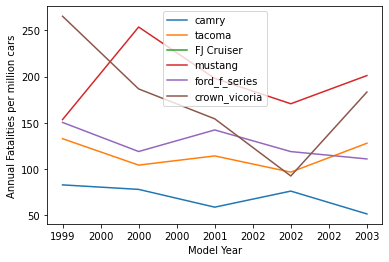

In [9]:
def summarize_by_modelyear( dfCrashAgg, modelYrStart, modelYrEnd, models_dict, dfSales=pd.DataFrame()): 
    # if dfSales is provided, it'll be used for normalization
    
    series={}
    for modelName,ID in models_dict.items():
        Make_ID  = ID['Make_ID']
        Model_ID = ID['Model_ID']
        condition = f'Make_ID=={Make_ID} and Model_ID=={Model_ID}'
        
        x,y=[],[]
        for modelYear in range(modelYrStart, modelYrEnd + 1):
            
            if not dfSales.empty:
                year, sales = lookupSales(
                    dfSales, Sales_Year=modelYear, Make_ID=Make_ID, Model_ID=Model_ID, verbose=False)
                
                # sales could be None if not found
                if sales != None:
                    salesTitle = f' ({year} sales of {sales} vehicles)'
            else:
                sales = None
                salesTitle = ''
            
            if dfSales.empty or sales!=None:
                _,_, initFatality = linear_regress(
                      dfCrashAgg      = dfCrashAgg
                    , name            = f'{modelYear} {modelName} {salesTitle}'
                    , filterCondition = f'MOD_YEAR=={modelYear} and ACC_YEAR>=MOD_YEAR and '+condition
                    , denom           = sales
                    , showPlot        = (modelYear>=modelYrStart)
                    )

                if initFatality != None:
                    x.append(modelYear)
                    y.append(initFatality)
        
        series[modelName] = [x,y]

    fig, ax = plt.subplots()

    for modelName,data in series.items():
        ax.plot(data[0], data[1], label=modelName)
    
    if not dfSales.empty:
        permillion = ' per million cars'
    else:
        permillion = ''
    
    ax.set_xlabel('Model Year')  # Add an x-label to the axes.
    ax.set_ylabel('Annual Fatalities' + permillion)  # Add a y-label to the axes.
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:4.0f}'))
    ax.legend()


if __name__ == '__main__':
    #     df_agg = aggregate(df_final, ['MOD_YEAR', 'Make_ID', 'Model_ID','ACC_YEAR'])
    x = {}
    x['camry' ]        = {'Make_ID':49, 'Model_ID':40 }   
    x['tacoma']        = {'Make_ID':49, 'Model_ID':472}   
    x['FJ Cruiser']    = {'Make_ID':49, 'Model_ID':404}   
    x['mustang']       = {'Make_ID':12, 'Model_ID':3  } 
    x['ford_f_series'] = {'Make_ID':12, 'Model_ID':481}   
    x['crown_vicoria'] = {'Make_ID':12, 'Model_ID':16 }  
    
    summarize_by_modelyear( dfMasterCrashAgg, modelYrStart=1999, modelYrEnd=2003, models_dict=x)
    summarize_by_modelyear( dfMasterCrashAgg, modelYrStart=1999, modelYrEnd=2003, models_dict=x, dfSales=dfSales)
    

# fig, ax = plt.subplots()  # Create a figure and an axes.
# ax.plot(x, x, label='linear')  # Plot some data on the axes.
# ax.plot(x, x**2, label='quadratic')  # Plot more data on the axes...
# ax.plot(x, x**3, label='cubic')  # ... and some more.
# ax.set_xlabel('x label')  # Add an x-label to the axes.
# ax.set_ylabel('y label')  # Add a y-label to the axes.
# ax.set_title("Simple Plot")  # Add a title to the axes.
# ax.legend()  # Add a legend.
    